In [1]:
import pandas
from preprocess import preprocess_dataset
from generate_exploratory_metrics import generate_exploratory_metrics
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from metrics import get_perf_metrics, save_conf_matrix, save_shap
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shap
import optuna

def preprocess_dataset(dataframe):
	#Drop the User ID (Not a useful feature)
	dataframe.drop(['User ID'], axis=1, inplace=True)

	# Convert categorical data to numerical data

	# Ordinal data
	dataframe["Physical Activity Level"] = dataframe["Physical Activity Level"].map({
		'low' : -1,
		'medium' : 0,
		'high': 1
	})

	dataframe["Dietary Habits"] = dataframe["Dietary Habits"].map({
		'healthy' : 1,
		'medium' : 0,
		'unhealthy' : -1,
	})

	# Binary data
	dataframe["Sleep Disorders"] = dataframe["Sleep Disorders"].map({
		'no' : -1,
		'yes' : 1,
	})

	dataframe["Medication Usage"] = dataframe["Medication Usage"].map({
		'no' : -1,
		'yes' : 1,
	})
	
	dataframe["Gender"] = dataframe["Gender"].map({
		'm' : -1,
		'f': 1
	})

	#Convert timestamps to numerical
	bedtimes = pandas.to_datetime(dataframe['Bedtime'], format='%H:%M')
	dataframe['Bedtime'] = bedtimes.dt.hour * 60 + bedtimes.dt.minute

	wake_times = pandas.to_datetime(dataframe['Wake-up Time'], format='%H:%M')
	dataframe['Wake-up Time'] = wake_times.dt.hour * 60 + wake_times.dt.minute

	# Standard normalization skipping ordinal data and target variable
	# We should only scale based on train data, not test data to prevent leakage
	# for column in dataframe.columns:
	# 	if not column in ["Gender", "Physical Activity Level", "Dietary Habits", "Sleep Disorders", "Medication Usage", "Sleep Quality"]:
	# 		dataframe[column] -= dataframe[column].mean()
	# 		dataframe[column] /= dataframe[column].std()



dataframe = pandas.read_csv("../data/Health_Sleep_Statistics.csv")
# Split train/test first
# Preprocessing should be called twice, once of the train data and once on the test data
# This ensures that we dont have data leakage
preprocess_dataset(dataframe)

y_data = dataframe["Sleep Quality"]
x_data = dataframe.drop(["Sleep Quality"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.5, random_state=42, stratify=dataframe["Sleep Quality"])

# Select columns to scale and standard scale based on training data only
scaling_columns = ["Age", "Bedtime", "Wake-up Time", "Daily Steps", "Calories Burned"]
scaler = StandardScaler()
x_train[scaling_columns] = scaler.fit_transform(x_train[scaling_columns])
x_test[scaling_columns] = scaler.transform(x_test[scaling_columns])


/home/msbean/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


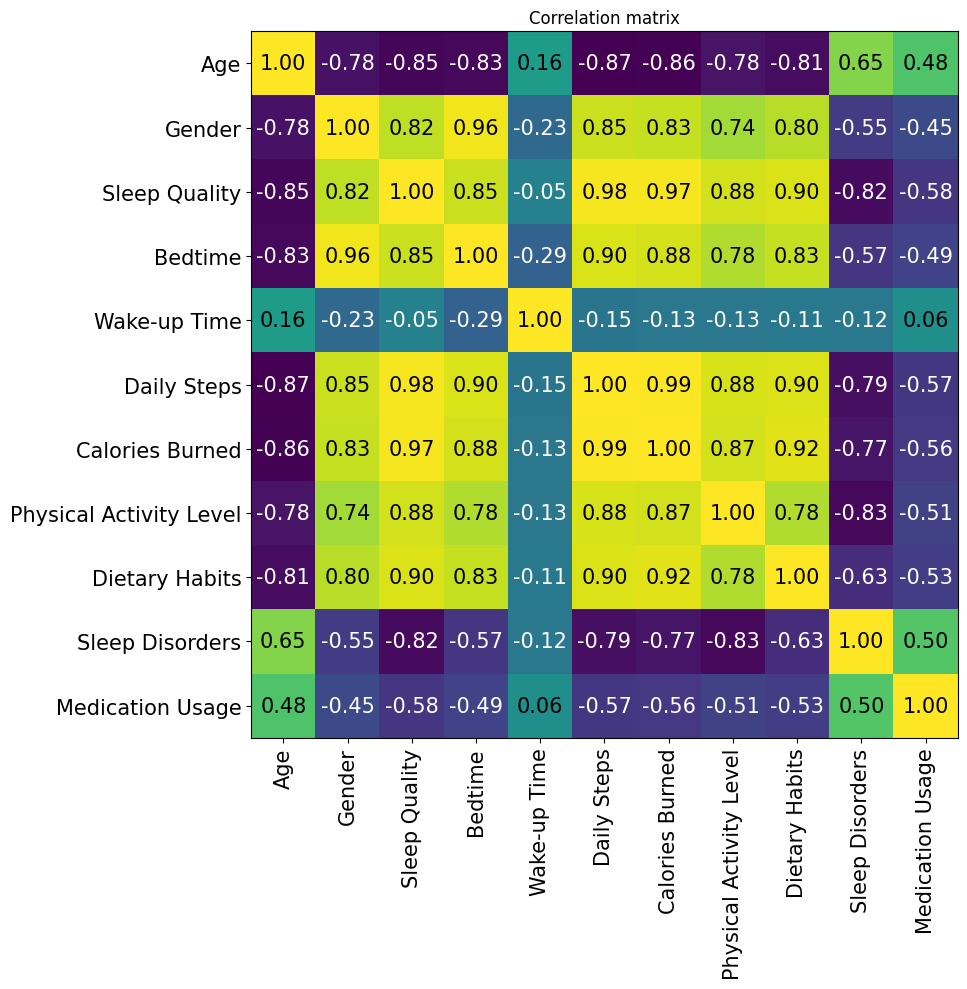

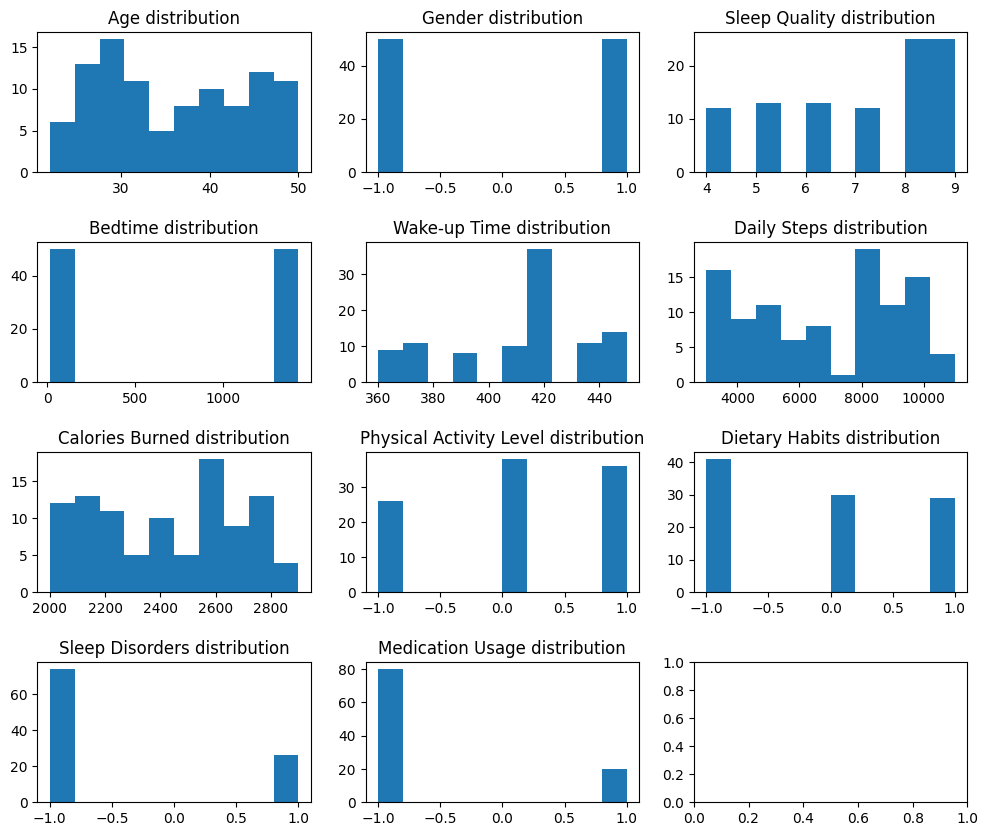

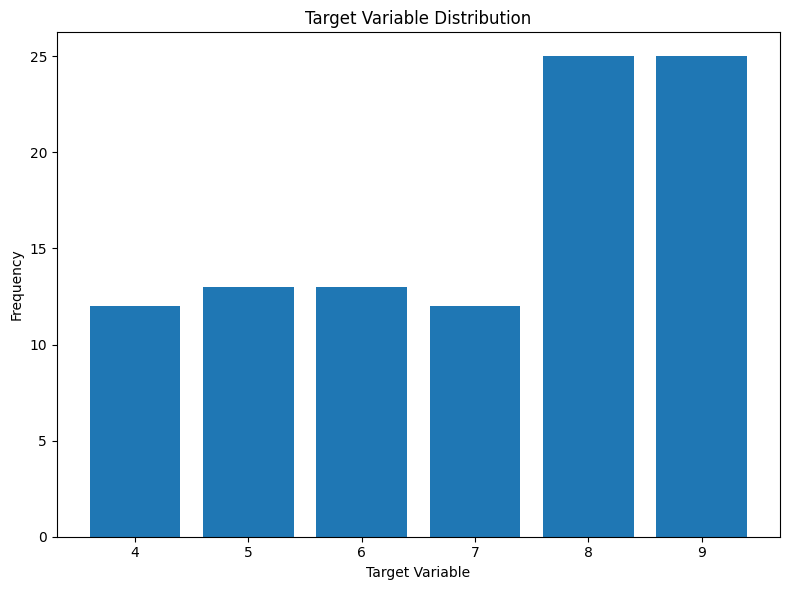

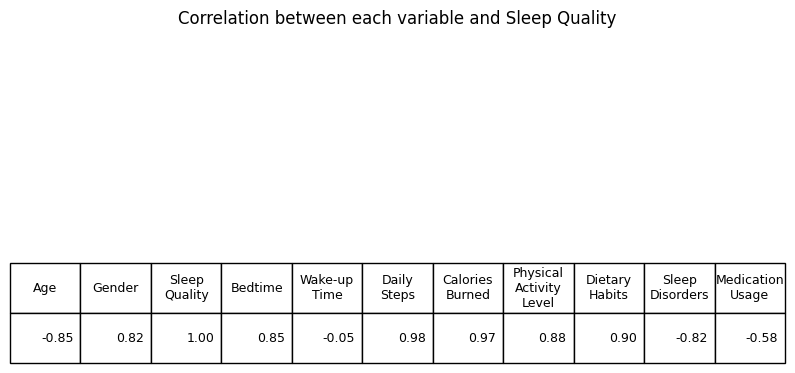

In [2]:
def generate_exploratory_metrics(dataframe):
	correlation_matrix = dataframe.corr()
	feature_names = dataframe.columns.to_numpy()
	
	#pyplot.figure()
	fig, ax = pyplot.subplots(figsize=(10, 10))
	pyplot.title('Correlation matrix')
	pyplot.xticks(rotation=90, ticks=range(len(feature_names)), labels = feature_names, fontsize=15)
	pyplot.yticks(ticks=range(len(feature_names)), labels = feature_names, fontsize=15)
	pyplot.imshow(correlation_matrix)
	pyplot.tight_layout()

	for i in range(len(feature_names)):
		for j in range(len(feature_names)):
			value = correlation_matrix[feature_names[i]][feature_names[j]]
			ax.text(j, i, f'{value:.2f}', ha='center', va='center', fontsize=15, color = 'black' if value > 0 else 'white')
			
	pyplot.show()
	pyplot.clf()
	pyplot.close()

	#pyplot.figure()
	fig, ax = pyplot.subplots(4, 3, figsize=(12, 10))
	for i in range(11):
		column = dataframe[feature_names[i]]
		ax[i // 3, i % 3].hist(column)
		ax[i // 3, i % 3].set_title(feature_names[i] + " distribution")

	pyplot.subplots_adjust(hspace=0.5)
	pyplot.show()
	pyplot.clf()
	pyplot.close()

	# Target variable distribution
	pyplot.figure(figsize=(8, 6))
	pyplot.bar(dataframe["Sleep Quality"].value_counts().sort_index().index, dataframe["Sleep Quality"].value_counts().sort_index().values)
	pyplot.title("Target Variable Distribution")
	pyplot.xlabel("Target Variable")
	pyplot.ylabel("Frequency")
	pyplot.tight_layout()
	pyplot.show()
	pyplot.clf()
	pyplot.close()

	#pyplot.figure()
	fig, ax = pyplot.subplots(figsize=(10, 3))
	pyplot.subplots_adjust(hspace=0)
	pyplot.axis('off')
	pyplot.title("Correlation between each variable and Sleep Quality")
	table = pyplot.table(cellText=[[f'{value:.2f}' for value in correlation_matrix['Sleep Quality'].to_numpy()]], colLabels=[name.replace(' ', '\n') for name in feature_names])
	table.scale(1, 3)
	table.auto_set_font_size(False)
	table.set_fontsize(9)
	pyplot.show()
	pyplot.clf()
	pyplot.close()

generate_exploratory_metrics(dataframe)

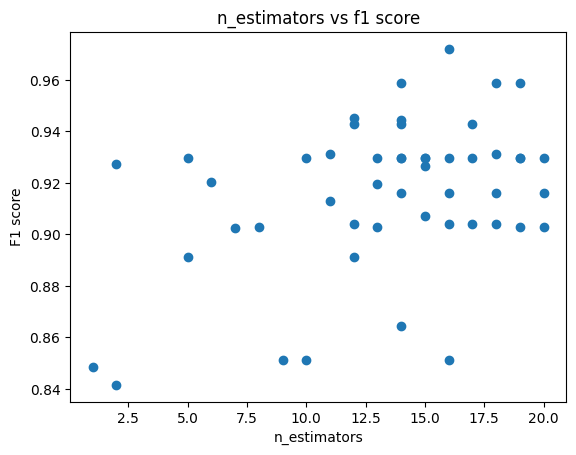

Optimized Random Forest Classifier
Precision: 0.919047619047619, Recall: 0.9166666666666666, F1: 0.9160839160839161, Accuracy: 0.94, AUC: 0.9965277777777778


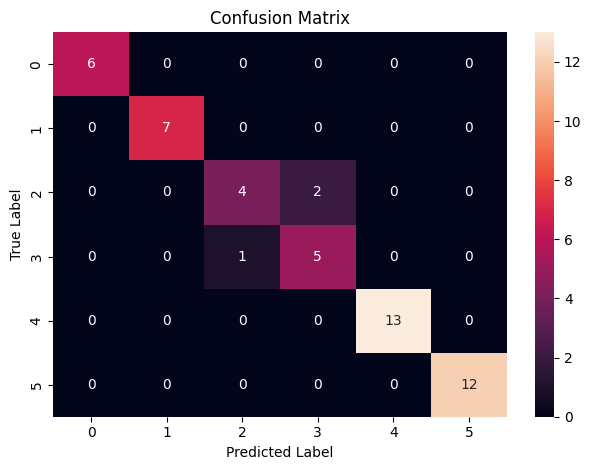

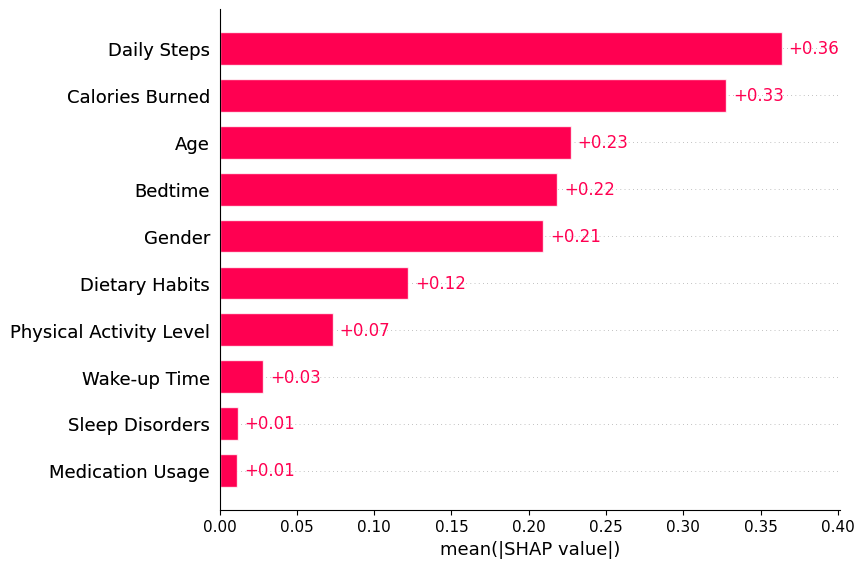

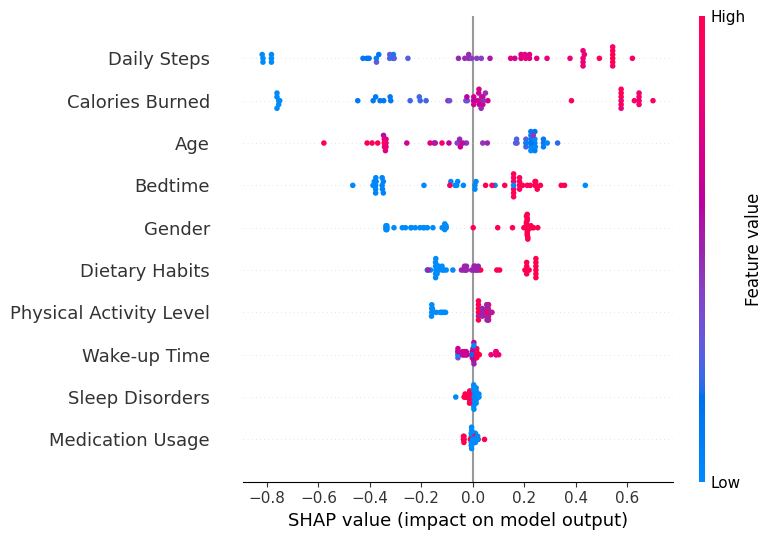

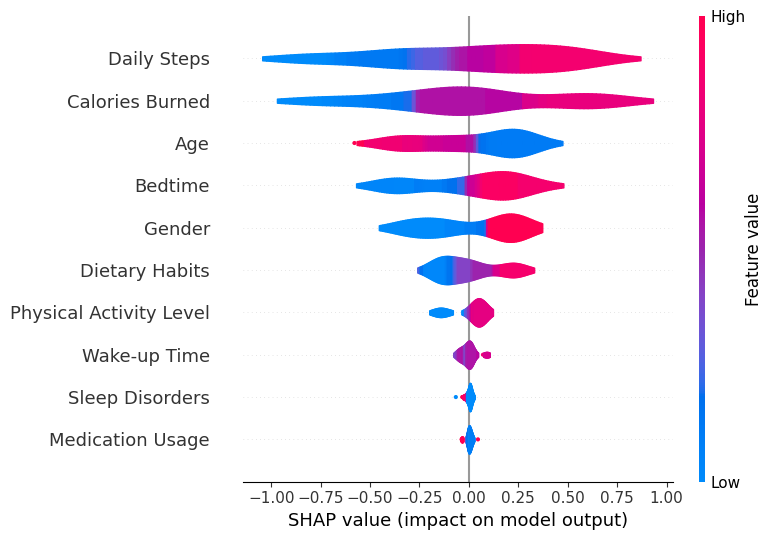

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix

def get_perf_metrics(y_test, model_pred, model_proba):
    #Returns precision, recall, f1, accuract, AUC
    return precision_score(y_test, model_pred, average='macro'), recall_score(y_test, model_pred, average='macro'), f1_score(y_test, model_pred, average='macro'), accuracy_score(y_test, model_pred), roc_auc_score(y_test, model_proba, multi_class='ovr')

def save_conf_matrix(y_test, model_pred, destination):
    #Saves confusion matrix in the destination
    conf_matrix = confusion_matrix(y_test, model_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    pyplot.title("Confusion Matrix")
    pyplot.xlabel("Predicted Label")
    pyplot.ylabel("True Label")
    pyplot.tight_layout()
    pyplot.show()
    pyplot.clf()
    pyplot.close()

def save_shap(model_predict, x_test, model_name):
    #This should be provided with model.predict, x_test, and a string that contains the model name
    explainer = shap.Explainer(model_predict, x_test)
    shap_values = explainer(x_test)

    shap.plots.bar(shap_values, show=False)
    pyplot.show()
    pyplot.clf()
    pyplot.close()

    shap.summary_plot(shap_values, show=False)
    pyplot.show()
    pyplot.clf()
    pyplot.close()

    shap.summary_plot(shap_values, plot_type='violin', show=False)
    pyplot.show()
    pyplot.clf()
    pyplot.close()


n_estimators_values = []
random_forest_f1_scores = []
# Random forest classifier
def random_forest_optimizer(trial):
	n_estimators = trial.suggest_int('n_estimators', 1, 20)
	random_forest = RandomForestClassifier(n_estimators = n_estimators) 
	random_forest.fit(x_train, y_train)
	random_forest_pred = random_forest.predict(x_test)
	random_forest_proba = random_forest.predict_proba(x_test)

	#Metrics
	precision, recall, f1, accuracy, auc = get_perf_metrics(y_test, random_forest_pred, random_forest_proba)
	n_estimators_values.append(n_estimators)
	random_forest_f1_scores.append(f1)
	return f1


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(random_forest_optimizer, n_trials=50)
n_estimators_optimal = study.best_params['n_estimators']

#Hyperparameter optimization graph
pyplot.figure()
pyplot.title("n_estimators vs f1 score")
pyplot.xlabel("n_estimators")
pyplot.ylabel("F1 score")
pyplot.scatter(n_estimators_values, random_forest_f1_scores)
pyplot.show()

random_forest = RandomForestClassifier(n_estimators = n_estimators_optimal) 
random_forest.fit(x_train, y_train)
random_forest_pred = random_forest.predict(x_test)
random_forest_proba = random_forest.predict_proba(x_test)

#Metrics
precision, recall, f1, accuracy, auc = get_perf_metrics(y_test, random_forest_pred, random_forest_proba)
print("Optimized Random Forest Classifier")
print("Precision: {}, Recall: {}, F1: {}, Accuracy: {}, AUC: {}".format(precision, recall, f1, accuracy, auc))

#Confusion Matrix
save_conf_matrix(y_test, random_forest_pred, '../assets/random_forest_confusion_matrix.jpg')

#SHAP values
save_shap(random_forest.predict, x_test, "random_forest")

/home/msbean/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msbean/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msbean/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msbean/.local/li

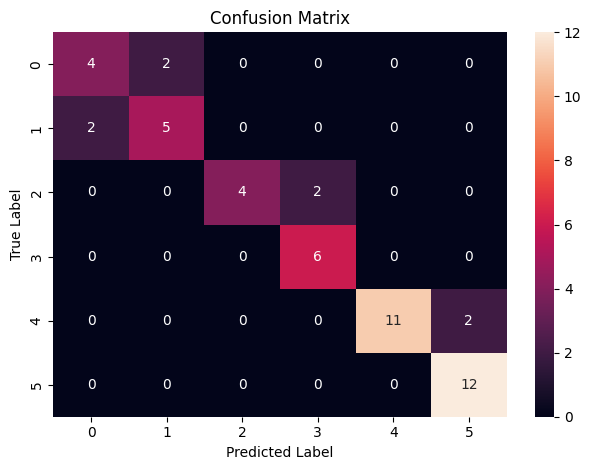

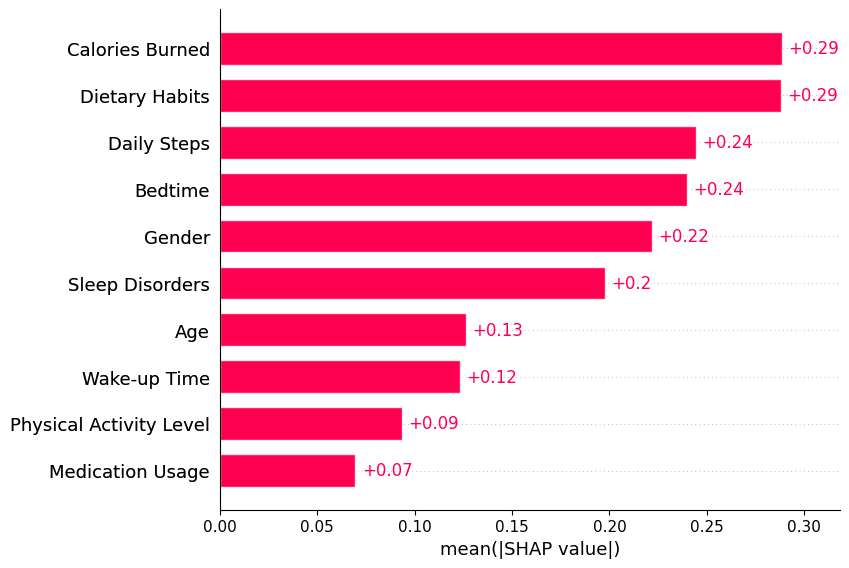

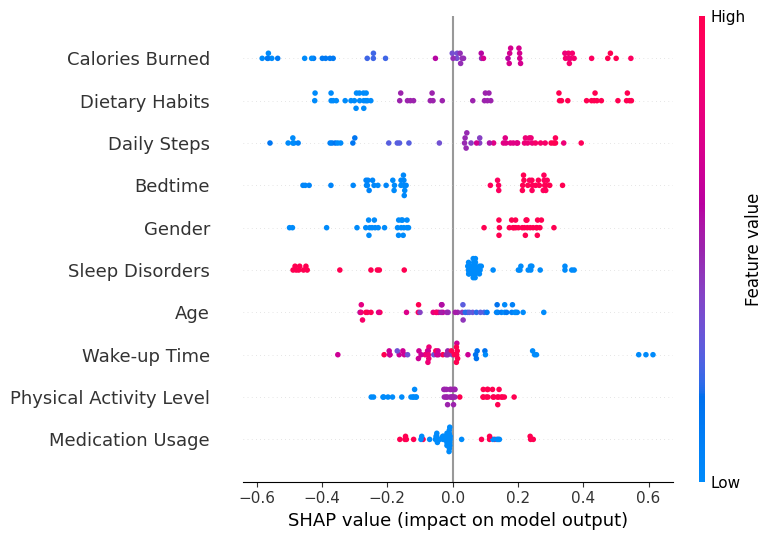

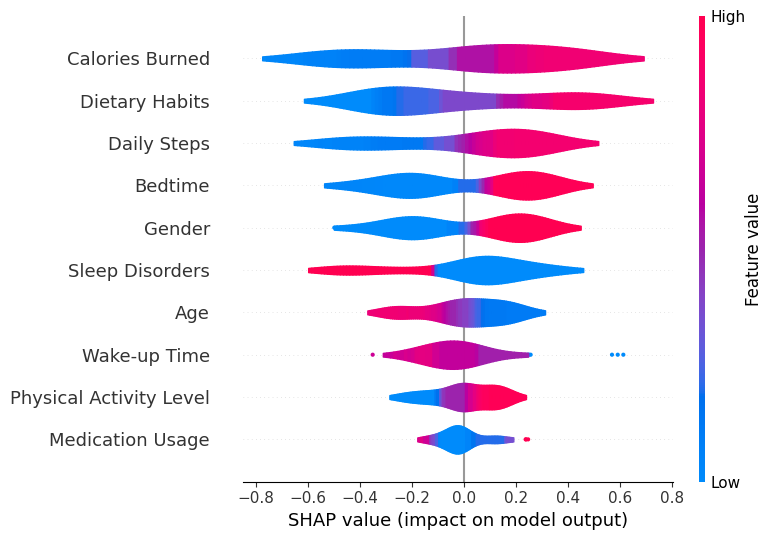

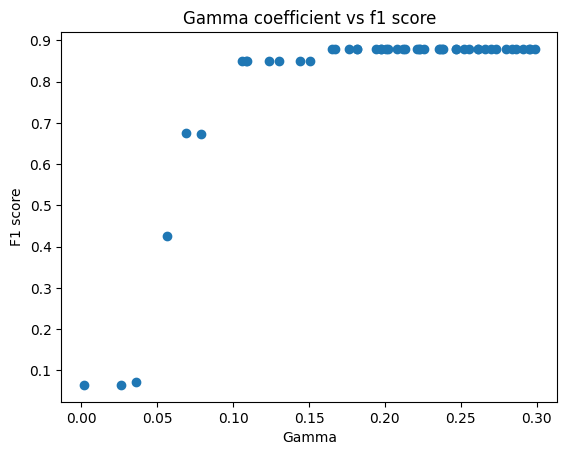

Optimized SVM
Precision: 0.8313492063492064, Recall: 0.8156288156288157, F1: 0.8129731379731381, Accuracy: 0.84, AUC: 0.9912287325078023


In [4]:

# Support Vector classifier
gamma_values = []
svm_f1_scores = []
def svm_optimizer(trial):
	gamma = trial.suggest_float('gamma', 0.0001, 0.3)
	gamma_values.append(gamma)
	svm = SVC(probability=True, kernel="poly", gamma=gamma) 
	svm.fit(x_train, y_train)
	svm_pred = svm.predict(x_test)
	svm_proba = svm.predict_proba(x_test)

	#Metrics
	precision, recall, f1, accuracy, auc = get_perf_metrics(y_test, svm_pred, svm_proba)

	svm_f1_scores.append(f1)
	return f1

study = optuna.create_study(direction="maximize")
study.optimize(svm_optimizer, n_trials=50)
gamma_optimal = study.best_params['gamma']

svm = SVC(probability=True, gamma=gamma_optimal) 
svm.fit(x_train, y_train)
svm_pred = svm.predict(x_test)
svm_proba = svm.predict_proba(x_test)

#Metrics
precision, recall, f1, accuracy, auc = get_perf_metrics(y_test, svm_pred, svm_proba)

#Confusion Matrix
save_conf_matrix(y_test, svm_pred, '../assets/svm_confusion_matrix.jpg')

#SHAP Values
save_shap(svm.predict, x_test, "svm")

#Hyperparameter optimization graph
pyplot.figure()
pyplot.title("Gamma coefficient vs f1 score")
pyplot.xlabel("Gamma")
pyplot.ylabel("F1 score")
pyplot.scatter(gamma_values, svm_f1_scores)
pyplot.show()

print("Optimized SVM")
print("Precision: {}, Recall: {}, F1: {}, Accuracy: {}, AUC: {}".format(precision, recall, f1, accuracy, auc))